In [12]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num_epochs = 5
batch_size = 4
learning_rate = 0.001


In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                            download = True, transform = transform)

test_dataset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                            download = True, transform = transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
classes = ('plane', 'car', 'bird', 'cat',
          'dear', 'dog', 'fog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

In [70]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

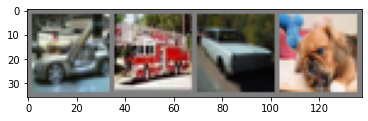

In [71]:
imshow(torchvision.utils.make_grid(images))

In [18]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [76]:
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [77]:
n_total_steps = len(train_loader) # 12500
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1)% 2000==0:
            print(f'epoch: {epoch}/{num_epochs}, step: {i+1}/{n_total_steps}, loss:{loss.item():.4f}')
            
print('Finished Training')
path = './cnn.pth'
torch.save(model.state_dict(), path)

epoch: 0/5, step: 2000/12500, loss:2.2602
epoch: 0/5, step: 4000/12500, loss:2.3239
epoch: 0/5, step: 6000/12500, loss:2.2875
epoch: 0/5, step: 8000/12500, loss:2.3084
epoch: 0/5, step: 10000/12500, loss:2.3568
epoch: 0/5, step: 12000/12500, loss:2.2505
epoch: 1/5, step: 2000/12500, loss:1.8974
epoch: 1/5, step: 4000/12500, loss:2.2374
epoch: 1/5, step: 6000/12500, loss:2.0294
epoch: 1/5, step: 8000/12500, loss:1.7947
epoch: 1/5, step: 10000/12500, loss:1.3296
epoch: 1/5, step: 12000/12500, loss:1.5642
epoch: 2/5, step: 2000/12500, loss:1.4636
epoch: 2/5, step: 4000/12500, loss:1.7486
epoch: 2/5, step: 6000/12500, loss:1.2508
epoch: 2/5, step: 8000/12500, loss:1.4395
epoch: 2/5, step: 10000/12500, loss:1.9904
epoch: 2/5, step: 12000/12500, loss:1.4290
epoch: 3/5, step: 2000/12500, loss:1.4980
epoch: 3/5, step: 4000/12500, loss:1.0757
epoch: 3/5, step: 6000/12500, loss:1.2033
epoch: 3/5, step: 8000/12500, loss:1.8750
epoch: 3/5, step: 10000/12500, loss:1.3863
epoch: 3/5, step: 12000/125

In [78]:
with torch.no_grad():
    n_correct = 0 
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        output = model(images)
        _, preds = torch.max(output,1)
        n_samples += 1
        n_correct += (pred==labels).sum().item()
        for i in range(batch_size):
            label = labels[i]
            pred = preds[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy: {acc:.4f}%')
    
    for i in range(10):
        acc = 100.0 * n_class_correct[i]/n_class_samples[i]
        print(f'accuracy of {classes[i]}: {acc}%')

accuracy: 39.6000%
accuracy of plane: 56.0%
accuracy of car: 76.0%
accuracy of bird: 28.2%
accuracy of cat: 29.0%
accuracy of dear: 45.0%
accuracy of dog: 41.2%
accuracy of fog: 61.9%
accuracy of horse: 55.0%
accuracy of ship: 58.6%
accuracy of truck: 38.9%


In [56]:
from captum.attr import IntegratedGradients
from captum.attr import Saliency
from captum.attr import DeepLift
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz

In [79]:
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    fog   dog   car horse


In [80]:
ind = 3

input = images[ind].unsqueeze(0)
input.requires_grad = True

In [81]:
model.eval()

ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [82]:
def attribute_image_features(algorithm, input, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(input,
                                              target=labels[ind],
                                              **kwargs
                                             )
    
    return tensor_attributions
        


In [83]:
saliency = Saliency(model)
grads = saliency.attribute(input, target=labels[ind].item())
grads = np.transpose(grads.squeeze().cpu().detach().numpy(), (1, 2, 0))


In [84]:
ig = IntegratedGradients(model)
attr_ig, delta = attribute_image_features(ig, input, baselines=input * 0, return_convergence_delta=True)
attr_ig = np.transpose(attr_ig.squeeze().cpu().detach().numpy(), (1, 2, 0))
print('Approximation delta: ', abs(delta))

Approximation delta:  tensor([0.0049], dtype=torch.float64)


In [85]:
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)
attr_ig_nt = attribute_image_features(nt, input, baselines=input * 0, nt_type='smoothgrad_sq',
                                      n_samples=100, stdevs=0.2)
attr_ig_nt = np.transpose(attr_ig_nt.squeeze(0).cpu().detach().numpy(), (1, 2, 0))

Original Image
Predicted: horse  Probability: 0.5395109057426453


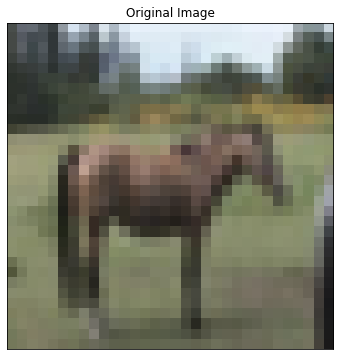

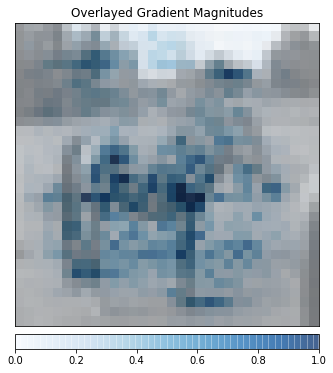

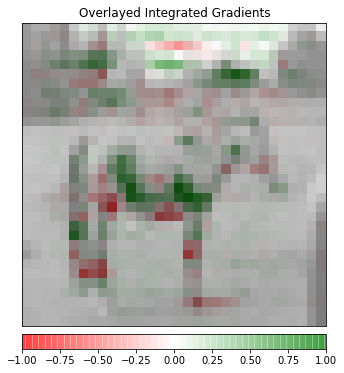

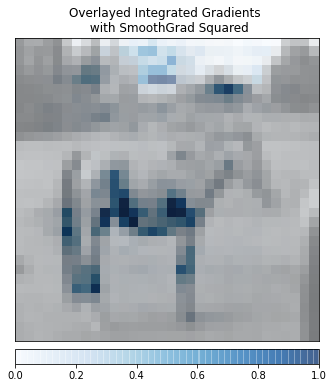

In [86]:
print('Original Image')
print('Predicted:', classes[predicted[ind]], 
      ' Probability:', torch.max(F.softmax(outputs, 1)).item())

original_image = np.transpose((images[ind].cpu().detach().numpy() / 2) + 0.5, (1, 2, 0))

_ = viz.visualize_image_attr(None, original_image, 
                      method="original_image", title="Original Image")

_ = viz.visualize_image_attr(grads, original_image, method="blended_heat_map", sign="absolute_value",
                          show_colorbar=True, title="Overlayed Gradient Magnitudes")

_ = viz.visualize_image_attr(attr_ig, original_image, method="blended_heat_map",sign="all",
                          show_colorbar=True, title="Overlayed Integrated Gradients")

_ = viz.visualize_image_attr(attr_ig_nt, original_image, method="blended_heat_map", sign="absolute_value", 
                             outlier_perc=10, show_colorbar=True, 
                             title="Overlayed Integrated Gradients \n with SmoothGrad Squared")

